In [5]:
%matplotlib ipympl
from onix.models.schiff import inverse_fa_limit, axion_frequency_to_mass, axion_mass_to_frequency
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from astropy.timeseries import LombScargle
from onix.papers.axion_2024.lomb_scargle import ls_psd_to_power_spectrum
from onix.papers.axion_2024.axion_gluon_bounds import best_exp_bounds, worse_exp_bounds, model_indep_theory_bounds
from onix.papers.axion_2024.axion_gluon import S_Flambaum, S_Sushkov, S_geo_mean, E_xtl, theta_from_W_T

In [6]:
raw_data = np.load("raw_data.npz")
start_times = raw_data["start_times"]
end_times = raw_data["end_times"]
Zs = raw_data["Zs"]
W_Ts = raw_data["W_Ts"]

center_times = (start_times + end_times) / 2
center_time_offset = center_times[0]
center_time_offsetted = center_times - center_time_offset
center_time_offsetted_h = center_time_offsetted / 3600
cycle_times = end_times - start_times
num_of_cycles = len(start_times)
total_duration = end_times[-1] - start_times[0]
delta_W_Ts = W_Ts - np.average(W_Ts)

cycle_time_avg = np.average(cycle_times)
cycle_frequency_avg = 1 / cycle_time_avg
W_T_unc = np.std(W_Ts) / np.sqrt(num_of_cycles)

In [7]:
frequency_sensitivities = np.load("frequency_sensitivities.npz")
sensitivity_func = interp1d(frequency_sensitivities["freqs_test"], frequency_sensitivities["sensitivities"])

In [8]:
ls = LombScargle(center_times, W_Ts, normalization="psd")

min_freq = 0.5 / total_duration
max_freq = 0.5 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
power_W_T = ls_psd_to_power_spectrum(f_W_T_psd, num_of_cycles)
freq_resolution = min_freq

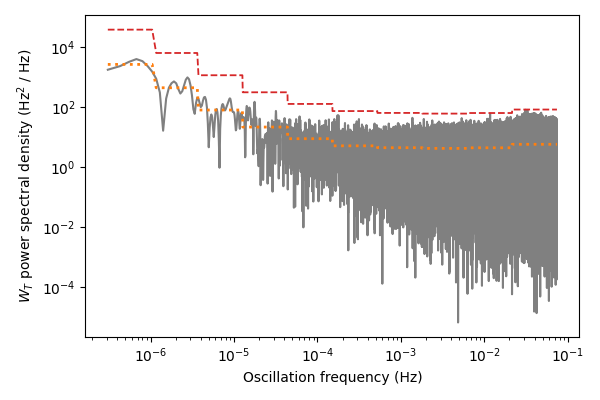

In [9]:
fs_bins = np.logspace(np.log10(np.min(fs) - 1e-10), np.log10(np.max(fs) + 1e-10), 10 + 1)
W_T_binned_indices = np.digitize(fs, fs_bins)
W_T_binned = []
for kk in range(1, len(fs_bins)):
    power_W_T_same_bin = power_W_T[W_T_binned_indices==kk]
    W_T_binned.extend([np.average(power_W_T_same_bin)] * len(power_W_T_same_bin))
W_T_binned = np.array(W_T_binned)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, power_W_T / freq_resolution, label="data", color="gray")
ax.plot(fs, W_T_binned / freq_resolution, label="binned average", color="C1", ls="dotted", linewidth=2)
global_95_bound = -np.log(1 - 0.95 ** (1/num_of_cycles)) * W_T_binned
ax.plot(fs, global_95_bound / freq_resolution, label=f"95% confidence level", color="C3", linewidth=1.3, ls="dashed")
ax.set_ylabel("$W_T$ power spectral density (Hz$^2$ / Hz)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend()
plt.tight_layout()
plt.savefig("spectrum.pdf")
plt.show()

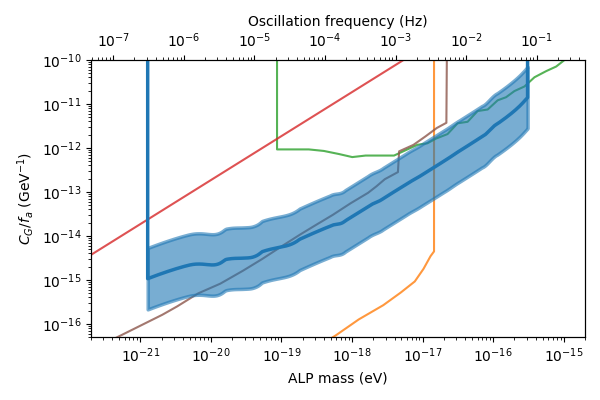

In [10]:
W_T_bound = np.sqrt(global_95_bound * 2 / sensitivity_func(fs))
fs_log = np.logspace(np.log10(np.min(fs) + 1e-12), np.log10(np.max(fs) - 1e-12), 100000)

W_T_bound_log = interp1d(fs, W_T_bound)(fs_log)
W_T_bound_log[:50000] = savgol_filter(W_T_bound_log[:50000], 20000, 2)
W_T_bound_log[40000:] = savgol_filter(W_T_bound_log[40000:], 4000, 2)
theta_bound_Flambaum = theta_from_W_T(W_T_bound_log, S_Flambaum, E_xtl)
theta_bound_Sushkov = theta_from_W_T(W_T_bound_log, S_Sushkov, E_xtl)
theta_bound_geo_mean = theta_from_W_T(W_T_bound_log, S_geo_mean, E_xtl)

stochastic_factor = 3
inverse_fa_bound_Flambaum = inverse_fa_limit(fs_log, theta_bound_Flambaum) * stochastic_factor
inverse_fa_bound_Sushkov = inverse_fa_limit(fs_log, theta_bound_Sushkov) * stochastic_factor
inverse_fa_bound_geo_mean = inverse_fa_limit(fs_log, theta_bound_geo_mean) * stochastic_factor

masses = axion_frequency_to_mass(fs_log)
fig, ax = plt.subplots(figsize=(6, 4))
ax1 = ax.twiny()
counter = 1
for kk in best_exp_bounds:
    temp_x = best_exp_bounds[kk][0]
    temp_y = best_exp_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C{counter}")
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C{counter}")
    counter += 1
    if counter == 1:
        counter += 1
for kk in worse_exp_bounds:
    temp_x = worse_exp_bounds[kk][0]
    temp_y = worse_exp_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C7")
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C{counter}")
    counter += 1
    if counter == 1 or counter == 4:
        counter += 1
for kk in model_indep_theory_bounds:
    temp_x = model_indep_theory_bounds[kk][0]
    temp_y = model_indep_theory_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C6")
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C6")
    counter += 1
    if counter == 1:
        counter += 1
#ax.fill_between(masses, inverse_fa_bound_Sushkov, 1, zorder=counter, color="gray", alpha=0.6)
#ax.fill_between(masses, inverse_fa_bound_Flambaum, 1, zorder=counter, color="gray", alpha=0.6)
ax.fill_between(masses, inverse_fa_bound_Flambaum, inverse_fa_bound_Sushkov, zorder=counter, color="C0", alpha=0.6,  linewidth=2.5)
ax.plot(
    np.append(np.append(masses[0], masses), masses[-1]),
    np.append(np.append(1, inverse_fa_bound_geo_mean), 1),
    color="C0", label="Eu:YSO (this work)", zorder=counter, alpha=1, linewidth=2.5,
)
ax.set_ylabel("$C_G / f_a$ (GeV${}^{-1}$)")
ax.set_xlabel("ALP mass (eV)")
ax1.set_xscale("log")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.5e-16, 1e-10)
#ax.set_xticks([1e-22, 1e-21, 1e-18, 1e-15, 1e-12])
ax.set_xlim(2e-22, 2e-15)
ax1.set_xlim(axion_mass_to_frequency(2e-22), axion_mass_to_frequency(2e-15))
#ax1.set_xticks([1e-9, 1e-7, 1e-5, 1e-3, 0.1, 10, 1000])
ax1.set_xlabel("Oscillation frequency (Hz)")
#ax.legend()
plt.tight_layout()
plt.show()

In [11]:
np.savez(
    "coherent_oscillation.npz",
    masses=masses,
    inverse_fa_bound_geo_mean=inverse_fa_bound_geo_mean,
)

In [12]:
print(len(fs))

603316


In [13]:
np.savez(
    "final_plots/spectrum.npz",
    freqs = fs,
    power_W_T = power_W_T / freq_resolution,
    power_W_T_binned = W_T_binned / freq_resolution,
    power_W_T_bound = global_95_bound / freq_resolution,
)